Approximate Chern number of layer A (Qi-Wu-Zhang): 0.000
Parent topological invariant (Chern): ~1 (since B is trivial).

Building real-space parent on 12 x 12 lattice...
dim(H_parent) = 576

Inside DOF (brane, B-layer only): 96
Outside DOF: 480

Computing PTB via Schur complement...

Diagonalizing parent and PTB (small system warning: O(N^3))...
Parent spectrum: min=-6.891, max=6.891
PTB spectrum:    min=-2.000, max=2.000


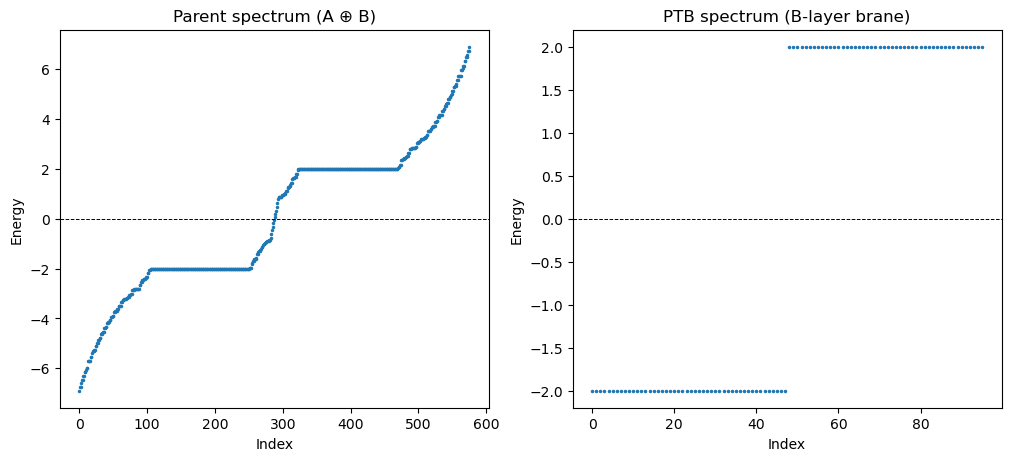


Interpretation:
 - Layer A alone has Chern ~1.
 - B-layer is trivial.
 - Parent = A ⊕ B is topological (Chern = 1).
 - The brane includes only B-layer DOFs in a strip.
 - The PTB is an effective Hamiltonian built purely from the trivial B-layer block.
 - Therefore the PTB is topologically trivial, even though the full parent is topological.


In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

########################################
# 0. Basic definitions
########################################

# Pauli matrices
tau_x = np.array([[0, 1], [1, 0]], dtype=complex)
tau_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
tau_z = np.array([[1, 0], [0, -1]], dtype=complex)
iden2 = np.eye(2, dtype=complex)

########################################
# 1. Chern number of layer A (Qi-Wu-Zhang model)
########################################

def H_A_k(kx, ky, t=1.0, t0=1.0, M=1.0):
    """
    Qi-Wu-Zhang / BHZ-like 2D Chern insulator in k-space.
    H_A(k) = d_x tau_x + d_y tau_y + d_z tau_z.
    """
    dx = t * np.sin(kx)
    dy = t * np.sin(ky)
    dz = M - 2.0 * t0 * (np.cos(kx) + np.cos(ky))
    return dx * tau_x + dy * tau_y + dz * tau_z

def berry_curvature_fukui(Hk_func, Nkx=21, Nky=21, **params):
    """
    Discrete Fukui-Hatsugai-Suzuki algorithm for Chern number of *lowest* band.
    Hk_func(kx, ky, **params) -> 2x2 Hamiltonian.
    """
    dkx = 2*np.pi / Nkx
    dky = 2*np.pi / Nky

    # Store eigenvectors of lowest band on grid
    U = np.zeros((Nkx, Nky, 2), dtype=complex)

    for ix in range(Nkx):
        kx = -np.pi + ix * dkx
        for iy in range(Nky):
            ky = -np.pi + iy * dky
            Hk = Hk_func(kx, ky, **params)
            w, v = np.linalg.eigh(Hk)
            # assume lowest band is index 0
            U[ix, iy, :] = v[:, 0]

    # Compute link variables
    F = 0.0 + 0.0j
    for ix in range(Nkx-1):
        for iy in range(Nky-1):
            u = U[ix,   iy,   :]
            ux = U[ix+1, iy,   :]
            uy = U[ix,   iy+1, :]
            uxy= U[ix+1, iy+1, :]

            # Gauge-invariant plaquette
            U1 = np.vdot(u, ux)
            U2 = np.vdot(ux, uxy)
            U3 = np.vdot(uxy, uy)
            U4 = np.vdot(uy, u)

            F += np.log(U1 * U2 * np.conj(U3) * np.conj(U4))

    chern = F.imag / (2*np.pi)
    return chern.real

########################################
# 2. Real-space parent: A (topological) ⊕ B (trivial)
########################################

def site_index(x, y, Lx):
    return y * Lx + x

def orb_index(x, y, layer, orb, Lx):
    """
    layer: 0 = A, 1 = B
    orb:   0,1
    global index = 4 * site + 2*layer + orb
    """
    s = site_index(x, y, Lx)
    return 4 * s + 2*layer + orb

def build_parent_realspace(Lx, Ly,
                           tA=1.0, t0A=1.0, MA=1.0,
                           DeltaB=2.0):
    """
    Build H_parent = H_A ⊕ H_B in real space
    on an Lx x Ly lattice with open boundaries.

    - Layer A: Chern insulator (Qi-Wu-Zhang real-space).
    - Layer B: trivial atomic insulator with onsite DeltaB tau_z and no hopping.
    """
    Ns = Lx * Ly
    dim = 4 * Ns

    rows, cols, data = [], [], []

    # -------- Layer A: topological Chern insulator --------
    # Onsite and hopping as in BHZ-like real-space form.
    # H_A onsite: (MA - 4 t0A) tau_z
    onsite_A = (MA - 4.0 * t0A) * tau_z
    Tx_A = t0A * tau_z + 0.5j * tA * tau_x   # +x hopping
    Ty_A = t0A * tau_z + 0.5j * tA * tau_y   # +y hopping

    # Onsite for A-layer
    for x in range(Lx):
        for y in range(Ly):
            for a in (0, 1):
                ia = orb_index(x, y, layer=0, orb=a, Lx=Lx)
                for b in (0, 1):
                    ib = orb_index(x, y, layer=0, orb=b, Lx=Lx)
                    rows.append(ia); cols.append(ib); data.append(onsite_A[a, b])

    # +x hopping for A-layer
    for x in range(Lx-1):
        for y in range(Ly):
            for a in (0, 1):
                ia = orb_index(x,   y, layer=0, orb=a, Lx=Lx)
                for b in (0, 1):
                    ib = orb_index(x+1, y, layer=0, orb=b, Lx=Lx)
                    v = Tx_A[a, b]
                    rows += [ia, ib]
                    cols += [ib, ia]
                    data += [v, np.conjugate(v)]

    # +y hopping for A-layer
    for x in range(Lx):
        for y in range(Ly-1):
            for a in (0, 1):
                ia = orb_index(x, y,   layer=0, orb=a, Lx=Lx)
                for b in (0, 1):
                    ib = orb_index(x, y+1, layer=0, orb=b, Lx=Lx)
                    v = Ty_A[a, b]
                    rows += [ia, ib]
                    cols += [ib, ia]
                    data += [v, np.conjugate(v)]

    # -------- Layer B: trivial atomic insulator --------
    # Only onsite DeltaB * tau_z, no hopping
    onsite_B = DeltaB * tau_z

    for x in range(Lx):
        for y in range(Ly):
            for a in (0, 1):
                ia = orb_index(x, y, layer=1, orb=a, Lx=Lx)
                for b in (0, 1):
                    ib = orb_index(x, y, layer=1, orb=b, Lx=Lx)
                    rows.append(ia); cols.append(ib); data.append(onsite_B[a, b])

    Hparent = sp.csr_matrix((data, (rows, cols)), shape=(dim, dim), dtype=complex)
    return Hparent

########################################
# 3. Brane mask: select ONLY B-layer DOFs inside a vertical strip
########################################

def brane_mask_B_only(Lx, Ly, x_min, x_max):
    """
    Brane: all B-layer orbitals on sites with x between x_min and x_max (inclusive).
    A-layer orbitals are NEVER inside the brane.
    """
    Ns = Lx * Ly
    dim = 4 * Ns
    mask = np.zeros(dim, dtype=bool)

    for x in range(Lx):
        for y in range(Ly):
            if x_min <= x <= x_max:
                # site (x,y) is in the brane region, but we include ONLY B-layer DOFs
                for orb in (0, 1):
                    idx_B = orb_index(x, y, layer=1, orb=orb, Lx=Lx)
                    mask[idx_B] = True
            # A-layer DOFs always remain outside, so do nothing for layer=0

    return mask

########################################
# 4. Schur complement PTB
########################################

def schur_ptb(Hparent, mask_in, E=0.0, eta=1e-6, permc_spec="MMD_AT_PLUS_A"):
    """
    Stabilized Schur complement PTB:
    H_PTB(E) = H11 - H12 (H22 - (E + i eta))^{-1} H21.
    """
    idx_in  = np.flatnonzero(mask_in)
    idx_out = np.flatnonzero(~mask_in)

    H11 = Hparent[idx_in[:, None],  idx_in].tocsc()
    H22 = Hparent[idx_out[:, None], idx_out].tocsc()
    H12 = Hparent[idx_in[:, None],  idx_out].tocsr()
    H21 = Hparent[idx_out[:, None], idx_in].tocsr()

    n_out = H22.shape[0]
    shift = (-E - 1j * eta)
    H22s = H22 + shift * sp.identity(n_out, dtype=complex, format="csc")
    lu = spla.splu(H22s, permc_spec=permc_spec, diag_pivot_thresh=1.0)

    X  = lu.solve(H21.toarray())         # (n_out, n_in)
    HX = H12 @ sp.csr_matrix(X)          # (n_in, n_in)
    Hptb = (H11 - HX).tocsr()
    # symmetrize
    Hptb = 0.5 * (Hptb + Hptb.getH())
    return Hptb

########################################
# 5. Main script: put everything together
########################################

if __name__ == "__main__":
    # ------------------------------
    # 5.1 Chern number of layer A
    # ------------------------------
    tA, t0A, MA = 1.0, 1.0, 1.0
    chern_A = berry_curvature_fukui(H_A_k, Nkx=21, Nky=21, t=tA, t0=t0A, M=MA)
    print(f"Approximate Chern number of layer A (Qi-Wu-Zhang): {chern_A:.3f}")

    # Parent's total Chern = C_A + C_B = 1 + 0 = 1
    print("Parent topological invariant (Chern): ~1 (since B is trivial).")

    # ------------------------------
    # 5.2 Build real-space parent
    # ------------------------------
    Lx, Ly = 12, 12
    DeltaB = 2.0

    print(f"\nBuilding real-space parent on {Lx} x {Ly} lattice...")
    Hparent = build_parent_realspace(Lx, Ly,
                                     tA=tA, t0A=t0A, MA=MA,
                                     DeltaB=DeltaB)
    dim = Hparent.shape[0]
    print(f"dim(H_parent) = {dim}")

    # ------------------------------
    # 5.3 Define B-only brane mask
    # ------------------------------
    # Take a vertical strip in the middle: x = 4..7
    x_min, x_max = 4, 7
    mask_in = brane_mask_B_only(Lx, Ly, x_min, x_max)
    nin = int(mask_in.sum())
    nout = dim - nin
    print(f"\nInside DOF (brane, B-layer only): {nin}")
    print(f"Outside DOF: {nout}")

    # ------------------------------
    # 5.4 Construct PTB via Schur complement
    # ------------------------------
    print("\nComputing PTB via Schur complement...")
    Hptb = schur_ptb(Hparent, mask_in, E=0.0, eta=1e-6)

    # ------------------------------
    # 5.5 Spectra: parent vs PTB
    # ------------------------------
    print("\nDiagonalizing parent and PTB (small system warning: O(N^3))...")
    # For this small system, dense diagonalization is fine
    eval_parent = np.linalg.eigvalsh(Hparent.toarray())
    eval_ptb    = np.linalg.eigvalsh(Hptb.toarray())

    print(f"Parent spectrum: min={eval_parent.min():.3f}, max={eval_parent.max():.3f}")
    print(f"PTB spectrum:    min={eval_ptb.min():.3f}, max={eval_ptb.max():.3f}")

    # Plot spectra for visual inspection
    fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), constrained_layout=True)

    axes[0].plot(eval_parent, ".", ms=3)
    axes[0].axhline(0, color="k", lw=0.7, ls="--")
    axes[0].set_title("Parent spectrum (A ⊕ B)")
    axes[0].set_xlabel("Index")
    axes[0].set_ylabel("Energy")

    axes[1].plot(eval_ptb, ".", ms=3)
    axes[1].axhline(0, color="k", lw=0.7, ls="--")
    axes[1].set_title("PTB spectrum (B-layer brane)")
    axes[1].set_xlabel("Index")
    axes[1].set_ylabel("Energy")

    plt.show()

    print("\nInterpretation:")
    print(" - Layer A alone has Chern ~1.")
    print(" - B-layer is trivial.")
    print(" - Parent = A ⊕ B is topological (Chern = 1).")
    print(" - The brane includes only B-layer DOFs in a strip.")
    print(" - The PTB is an effective Hamiltonian built purely from the trivial B-layer block.")
    print(" - Therefore the PTB is topologically trivial, even though the full parent is topological.")


Eigenvalue range: -5.96925577495845 5.969255774958451
Approximate bulk Chern (from center site): 0.9999995169362754


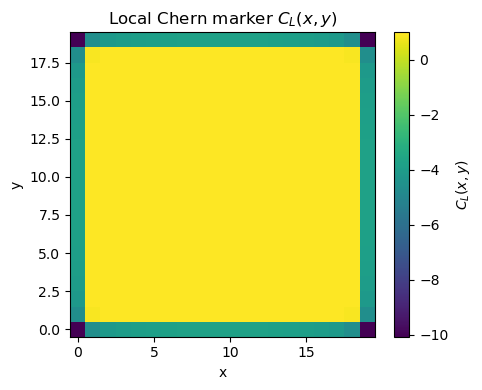

In [7]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

# ---------- Pauli ----------
tau_x = np.array([[0, 1], [1, 0]], dtype=complex)
tau_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
tau_z = np.array([[1, 0], [0, -1]], dtype=complex)

# ---------- Indexing ----------
def site_index(x, y, orb, Lx):
    """
    Map (x, y, orbital) to a single Hilbert-space index.
    orb = 0,1 for the two tau orbitals.
    """
    return 2 * (y * Lx + x) + orb


def inverse_site_index(i, Lx):
    """
    Inverse of site_index: from basis index i -> (x, y, orb).
    """
    site = i // 2
    orb = i % 2
    y = site // Lx
    x = site % Lx
    return x, y, orb

# ---------- Parent BHZ (Eq. S16, up to sign convention) ----------
def build_BHZ_parent(Lx, Ly, t=2.0, t0=1.0, m=2.0):
    """
    Real-space BHZ Hamiltonian on an Lx x Ly square lattice
    with open boundary conditions (as in your snippet).
    """
    N = 2 * Lx * Ly
    rows, cols, data = [], [], []

    # On-site and hopping matrices
    # Your onsite term: onsite = -(4 t0 - m) tau_z
    onsite = -(4.0 * t0 - m) * tau_z
    Tx = t0 * tau_z + 1j * (t / 2.0) * tau_x
    Ty = t0 * tau_z + 1j * (t / 2.0) * tau_y

    # On-site contribution
    for x in range(Lx):
        for y in range(Ly):
            for a in (0, 1):
                ia = site_index(x, y, a, Lx)
                for b in (0, 1):
                    ib = site_index(x, y, b, Lx)
                    rows.append(ia)
                    cols.append(ib)
                    data.append(onsite[a, b])

    # +x hopping (and H.c.)
    for x in range(Lx - 1):
        for y in range(Ly):
            for a in (0, 1):
                ia = site_index(x, y, a, Lx)
                for b in (0, 1):
                    ib = site_index(x + 1, y, b, Lx)
                    v = Tx[a, b]
                    # ia -> ib
                    rows.append(ia); cols.append(ib); data.append(v)
                    # H.c.: ib -> ia
                    rows.append(ib); cols.append(ia); data.append(np.conjugate(v))

    # +y hopping (and H.c.)
    for x in range(Lx):
        for y in range(Ly - 1):
            for a in (0, 1):
                ia = site_index(x, y, a, Lx)
                for b in (0, 1):
                    ib = site_index(x, y + 1, b, Lx)
                    v = Ty[a, b]
                    # ia -> ib
                    rows.append(ia); cols.append(ib); data.append(v)
                    # H.c.: ib -> ia
                    rows.append(ib); cols.append(ia); data.append(np.conjugate(v))

    H = sp.csr_matrix((data, (rows, cols)), shape=(N, N), dtype=complex)
    return H

# ---------- Position Operators ----------
def build_position_operators(Lx, Ly):
    """
    Build X and Y as diagonal operators in the same basis as H.
    We set lattice spacing a = 1 and use x,y = 0,...,Lx-1,Ly-1.
    """
    N = 2 * Lx * Ly
    X = np.zeros((N, N), dtype=complex)
    Y = np.zeros((N, N), dtype=complex)

    for x in range(Lx):
        for y in range(Ly):
            for orb in (0, 1):
                i = site_index(x, y, orb, Lx)
                X[i, i] = x  # or x+0.5, doesn't matter for topology
                Y[i, i] = y

    return X, Y

# ---------- Local Chern Marker ----------
def compute_local_chern_marker(H_sparse, Lx, Ly, energy_threshold=0.0):
    """
    Compute the Bianco–Resta local Chern marker C_L(x,y) for
    the BHZ Hamiltonian H_sparse on an Lx x Ly lattice.

    Steps:
    1) Diagonalize H.
    2) Build projector P onto E < energy_threshold (occupied states).
    3) Construct Ĉ_L = -4π Im[ P X Q Y P ] with Q = I - P.
    4) Extract C_L(x,y) by summing over the two orbitals at each site.
    """
    # Convert to dense Hermitian
    H = H_sparse.toarray()
    # Enforce Hermiticity numerically
    H = 0.5 * (H + H.conj().T)

    N = H.shape[0]
    # Full diagonalization (OK for moderate N ~ O(10^3))
    evals, evecs = np.linalg.eigh(H)

    # Occupied states: energies below threshold
    occ_mask = evals < energy_threshold
    if not np.any(occ_mask):
        raise ValueError("No occupied states found below threshold; adjust energy_threshold.")

    # Projector onto occupied subspace: P = sum_n |ψ_n><ψ_n|
    psi_occ = evecs[:, occ_mask]          # shape (N, N_occ)
    P = psi_occ @ psi_occ.conj().T        # (N x N) dense

    # Complement projector
    I = np.eye(N, dtype=complex)
    Q = I - P

    # Position operators
    X, Y = build_position_operators(Lx, Ly)

    # Chern operator: Ĉ_L = -4π Im [ P X Q Y P ]
    PX = P @ X
    QY = Q @ Y
    C_op = -4.0 * np.pi * np.imag(PX @ QY @ P)

    # Local marker at each basis state is the diagonal
    C_diag = np.real(np.diag(C_op))  # should be real within numerical accuracy

    # Sum over orbitals for each (x,y)
    CL_map = np.zeros((Lx, Ly), dtype=float)
    for x in range(Lx):
        for y in range(Ly):
            iA = site_index(x, y, 0, Lx)
            iB = site_index(x, y, 1, Lx)
            CL_map[x, y] = C_diag[iA] + C_diag[iB]

    return CL_map, evals

# ---------- Example usage ----------
if __name__ == "__main__":
    # Lattice size
    Lx, Ly = 20, 20   # you can increase, e.g. 20x20, if your RAM allows

    # BHZ parameters; choose m/t0 in the topological regime (0<m/t0<8)
    t = 2.0
    t0 = 1.0
    m = 2.0          # Γ phase, C = -1 in momentum space

    # Build Hamiltonian and compute local Chern marker
    H = build_BHZ_parent(Lx, Ly, t=t, t0=t0, m=m)
    CL_map, evals = compute_local_chern_marker(H, Lx, Ly, energy_threshold=0.0)

    print("Eigenvalue range:", evals.min(), evals.max())
    print("Approximate bulk Chern (from center site):", CL_map[Lx//2, Ly//2])

    # Plot C_L(x,y)
    plt.figure(figsize=(5, 4))
    plt.imshow(CL_map.T, origin='lower', interpolation='nearest')
    plt.colorbar(label=r'$C_L(x,y)$')
    plt.title(r'Local Chern marker $C_L(x,y)$')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.show()


Lattice: 40 x 40  -> dim(H) = 3200


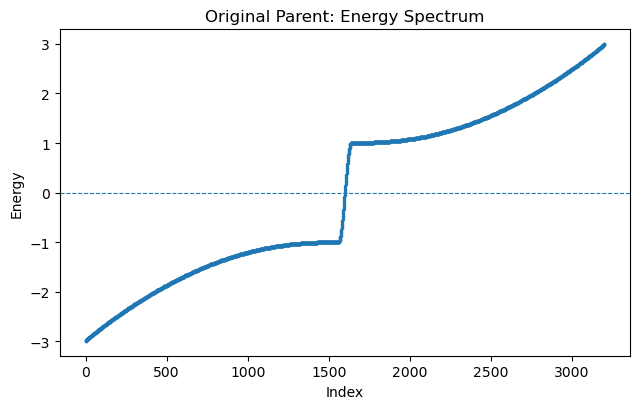

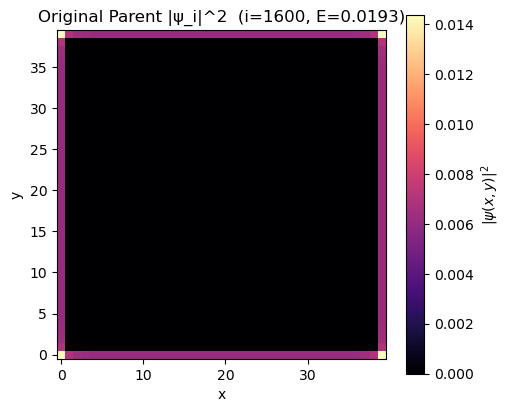

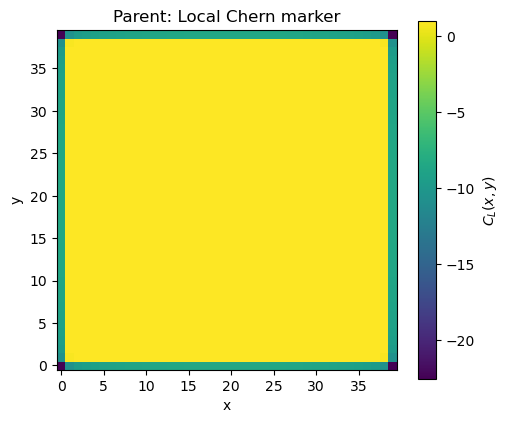

Bulk C_L (original parent) = 0.9999999999995146
Bulk mean = 0.9971985234077805
[[0.78140465 0.9678179  0.98148389 ... 0.98148389 0.9678179  0.78140465]
 [0.9678179  0.99241085 0.99528954 ... 0.99528954 0.99241085 0.9678179 ]
 [0.98148389 0.99528954 0.99827743 ... 0.99827743 0.99528954 0.98148389]
 ...
 [0.98148389 0.99528954 0.99827743 ... 0.99827743 0.99528954 0.98148389]
 [0.9678179  0.99241085 0.99528954 ... 0.99528954 0.99241085 0.9678179 ]
 [0.78140465 0.9678179  0.98148389 ... 0.98148389 0.9678179  0.78140465]]


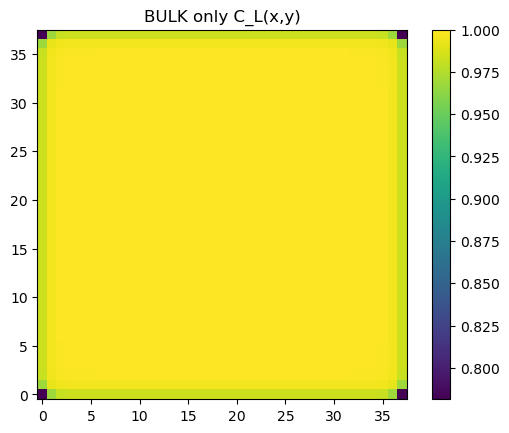

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


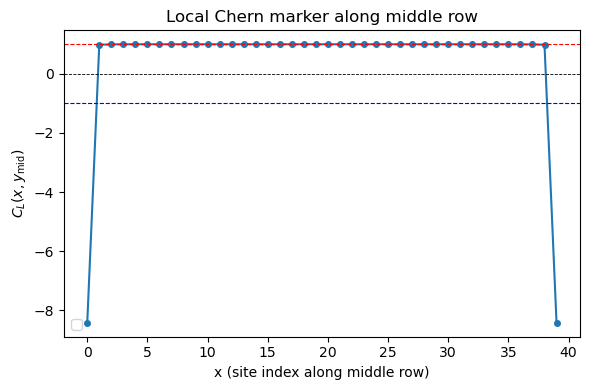

Inside DOF: 260 | Outside DOF: 2940


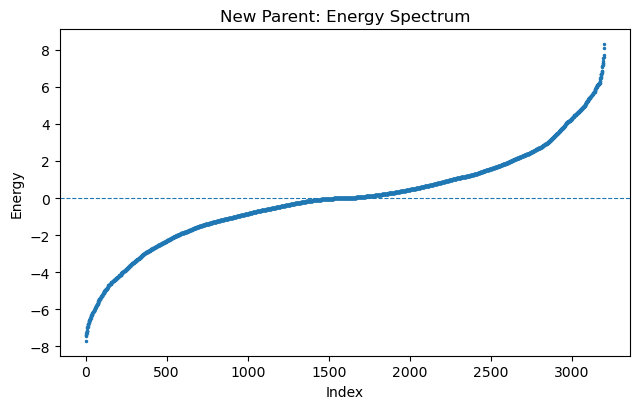

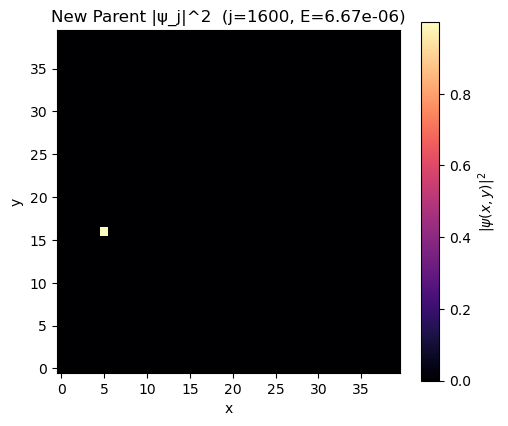

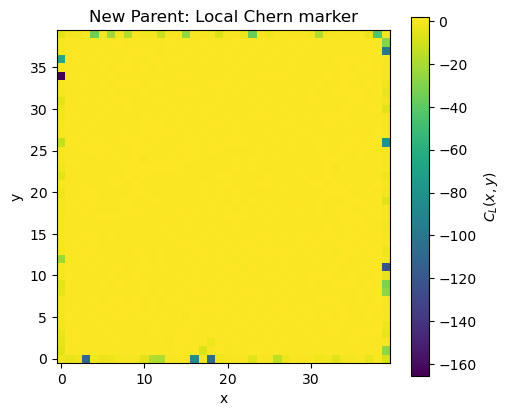

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Bulk C_L (new parent) = 0.6819359768910137


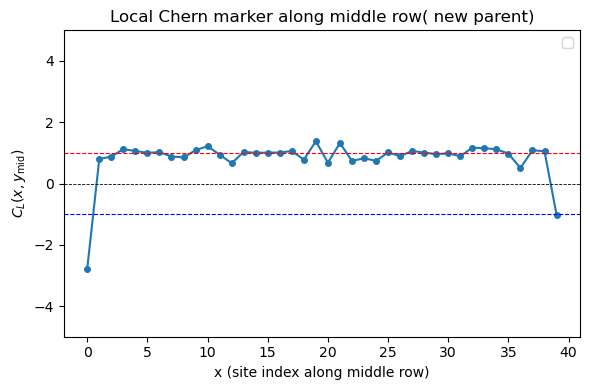

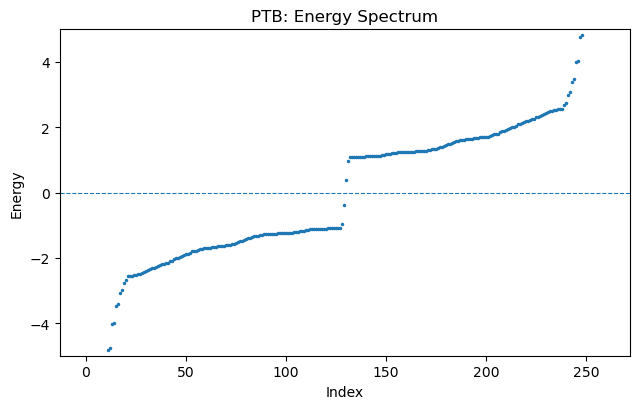

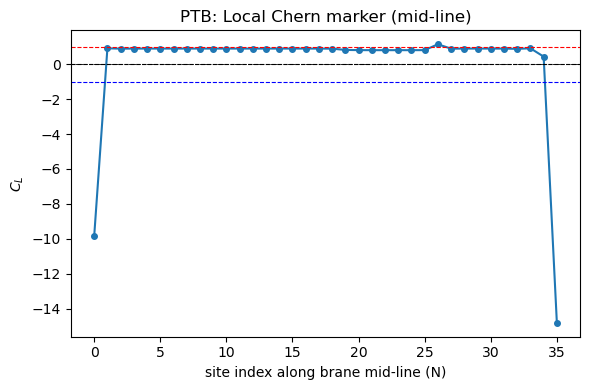

C_L at lattice center for PTB = 0.0


In [ ]:
# CORRECT ONE FOR EIGEN STATES PROBABIITY DENSITY PLOTTING FOR ORIGINAL VS \GAMMA PARENT
# 
# ============================================================
# BHZ parent -> (spectrum + |psi_i|^2 + local Chern marker)
# New parent with Gamma -> (spectrum + |psi_j|^2 + local Chern marker)
# PTB -> (spectrum + local Chern marker)
# ============================================================

import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

# ---------- Pauli ----------
tau_x = np.array([[0, 1], [1, 0]], dtype=complex)
tau_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
tau_z = np.array([[1, 0], [0, -1]], dtype=complex)

# ---------- Indexing ----------
def site_index(x, y, orb, Lx):
    """site linear = y*Lx + x, then *2 for orbitals + orb"""
    return 2 * (y * Lx + x) + orb

def inverse_site_index(i, Lx):
    """Inverse of site_index: from basis index i -> (x, y, orb)."""
    site = i // 2
    orb = i % 2
    y = site // Lx
    x = site % Lx
    return x, y, orb

# ---------- Parent BHZ (Eq. S16) ----------
def build_BHZ_parent(Lx, Ly, t=2.0, t0=1.0, m=2.0):
    """
    Real-space BHZ (spinless) with open boundaries.
    H_on = (m-4 t0) τ_z
    H_x  =  t0 τ_z + (i t/2) τ_x
    H_y  =  t0 τ_z + (i t/2) τ_y
    Returns: H (csr), shape (2*Lx*Ly, 2*Lx*Ly)
    """
    N = 2 * Lx * Ly
    rows, cols, data = [], [], []

    # onsite = -(4.0 * t0 - m) * tau_z
    # Tx = t0 * tau_z + 1j * (t / 2.0) * tau_x
    # Ty = t0 * tau_z + 1j * (t / 2.0) * tau_y
        # --- CHANGED: onsite and signs in Tx, Ty ---
    onsite = (4.0 * t0 - m) * tau_z
    Tx = -t0 * tau_z - 1j * (t / 2.0) * tau_x
    Ty = -t0 * tau_z - 1j * (t / 2.0) * tau_y
    # On-site
    for x in range(Lx):
        for y in range(Ly):
            for a in (0, 1):
                ia = site_index(x, y, a, Lx)
                for b in (0, 1):
                    ib = site_index(x, y, b, Lx)
                    rows.append(ia); cols.append(ib); data.append(onsite[a, b])

    # +x hopping (and H.c.)
    for x in range(Lx - 1):
        for y in range(Ly):
            for a in (0, 1):
                ia = site_index(x, y, a, Lx)
                for b in (0, 1):
                    ib = site_index(x + 1, y, b, Lx)
                    v = Tx[a, b]
                    rows += [ia, ib]; cols += [ib, ia]; data += [v, np.conjugate(v)]

    # +y hopping (and H.c.)
    for x in range(Lx):
        for y in range(Ly - 1):
            for a in (0, 1):
                ia = site_index(x, y, a, Lx)
                for b in (0, 1):
                    ib = site_index(x, y + 1, b, Lx)
                    v = Ty[a, b]
                    rows += [ia, ib]; cols += [ib, ia]; data += [v, np.conjugate(v)]

    H = sp.csr_matrix((data, (rows, cols)), shape=(N, N), dtype=complex)
    return H

# ---------- Brane (arbitrary angle) ----------
def brane_mask(Lx, Ly, theta=None, S=None, x_u=12.0, x_d=6.0, xt_u=1.0, xt_d=2.0, inclusive=True):
    """
    Return boolean mask (length = 2*Lx*Ly) for DOFs inside the brane.
    Brane is the strip between two lines with slope S = tan(theta):
        y_u(x) = S*(x - xt_u) + x_u
        y_d(x) = S*(x - xt_d) + x_d
    """
    if S is None:
        if theta is None:
            raise ValueError("Provide either theta or S.")
        S = np.tan(theta)

    yu = np.zeros(Lx, dtype=float)
    yd = np.zeros(Lx, dtype=float)
    for x in range(Lx):
        yu[x] = S * (x - xt_u) + x_u
        yd[x] = S * (x - xt_d) + x_d
        if yd[x] > yu[x]:
            yu[x], yd[x] = yd[x], yu[x]  # ensure yu >= yd

    mask_sites = np.zeros((Ly, Lx), dtype=bool)  # [y, x]
    for x in range(Lx):
        y_top = yu[x]; y_bot = yd[x]
        for y in range(Ly):
            inside = (y_bot <= y <= y_top) if inclusive else (y_bot < y < y_top)
            if inside:
                mask_sites[y, x] = True

    # Repeat for the 2 orbitals per site
    mask_orb = np.repeat(mask_sites.flatten(), 2)  # flatten() is C-order: index = y*Lx + x
    return mask_orb

# ---------- Stabilized Schur complement for PTB ----------
def schur_ptb(Hparent, mask_in, E=0.0, eta=1e-6, permc_spec="MMD_AT_PLUS_A", make_hermitian=True):
    idx_in  = np.flatnonzero(mask_in)
    idx_out = np.flatnonzero(~mask_in)

    # Extract blocks
    H11 = Hparent[idx_in[:, None], idx_in].tocsc()
    H22 = Hparent[idx_out[:, None], idx_out].tocsc()
    H12 = Hparent[idx_in[:, None], idx_out].tocsr()
    H21 = Hparent[idx_out[:, None], idx_in].tocsr()

    # Stabilize and factorize H22
    n_out = H22.shape[0]
    shift = (-E - 1j * eta)
    H22s = H22 + shift * sp.identity(n_out, dtype=complex, format="csc")
    lu = spla.splu(H22s, permc_spec=permc_spec, diag_pivot_thresh=1.0)

    # Solve for multiple RHS: H22s X = H21
    X = lu.solve(H21.toarray())              # shape: (n_out, n_in)
    HX = H12 @ sp.csr_matrix(X)              # (n_in, n_in)
    Hptb = (H11 - HX).tocsr()
    if make_hermitian:
        Hptb = 0.5 * (Hptb + Hptb.getH())
    return Hptb

# ---------- Utilities ----------
def full_spectrum(H):
    """All eigenvalues of a Hermitian sparse matrix H (dense solve)."""
    return np.linalg.eigvalsh(H.toarray())

def ith_density_from_eigvec(vec, Lx, Ly):
    """vec is length 2*Lx*Ly; returns rho[y,x] = sum_orb |psi|^2."""
    psi_site_orb = vec.reshape(Lx*Ly, 2)
    dens_site = np.sum(np.abs(psi_site_orb)**2, axis=1)
    return dens_site.reshape(Ly, Lx)

def plot_density(rho, title):
    plt.figure(figsize=(5.2, 4.6))
    im = plt.imshow(rho, origin="lower", interpolation="nearest", cmap="magma")
    plt.colorbar(im, shrink=0.9, label=r"$|\psi(x,y)|^2$")
    plt.xlabel("x"); plt.ylabel("y"); plt.title(title)
    plt.tight_layout(); plt.show()

# ---------- Local Chern marker helpers (ADDED) ----------
def compute_local_chern_marker_subspace(H_sparse, Lx, Ly, idx_subset=None,
                                        energy_threshold=0.0, title="Local Chern marker"):
    """
    Generic local Chern marker for a subspace of the full Hilbert space.
    - H_sparse: full Hamiltonian in parent basis.
    - idx_subset: indices of DOFs to keep (None -> all DOFs).
    Returns CL_map[Ly, Lx] and eigenvalues in the subspace.
    """
    N_full = H_sparse.shape[0]
    if idx_subset is None:
        idx_subset = np.arange(N_full, dtype=int)
    idx_subset = np.asarray(idx_subset, dtype=int)
    N_sub = idx_subset.size

    # Subspace Hamiltonian
    H_sub = H_sparse[idx_subset[:, None], idx_subset].toarray()
    H_sub = 0.5 * (H_sub + H_sub.conj().T)  # enforce Hermiticity

    # Diagonalize
    evals, evecs = np.linalg.eigh(H_sub)

    # Occupied states
    occ_mask = evals < energy_threshold
    if not np.any(occ_mask):
        raise ValueError("No occupied states found below threshold in subspace.")
    psi_occ = evecs[:, occ_mask]          # (N_sub, N_occ)
    P = psi_occ @ psi_occ.conj().T        # (N_sub, N_sub)
    I = np.eye(N_sub, dtype=complex)
    Q = I - P

    # Position operators in the subspace, using parent coordinates
    X = np.zeros((N_sub, N_sub), dtype=complex)
    Y = np.zeros((N_sub, N_sub), dtype=complex)
    for a, i_glob in enumerate(idx_subset):
        x, y, orb = inverse_site_index(i_glob, Lx)
        X[a, a] = x
        Y[a, a] = y

    # Ĉ_L = -4π Im[P X Q Y P]
    C_op = -4.0 * np.pi * np.imag(P @ X @ Q @ Y @ P)
    C_diag = np.real(np.diag(C_op))

    # Accumulate per site (sum over orbitals)
    CL_map = np.zeros((Ly, Lx), dtype=float)
    for a, i_glob in enumerate(idx_subset):
        x, y, orb = inverse_site_index(i_glob, Lx)
        CL_map[y, x] += C_diag[a]

    # Plot
    plt.figure(figsize=(5.2, 4.6))
    im = plt.imshow(CL_map, origin="lower", interpolation="nearest")
    plt.colorbar(im, shrink=0.9, label=r"$C_L(x,y)$")
    plt.xlabel("x"); plt.ylabel("y")
    plt.title(title)
    plt.tight_layout(); plt.show()

    return CL_map, evals

def compute_local_chern_marker_ptb(Hptb, Lx, Ly, idx_in,
                                   energy_threshold=0.0,
                                   title="PTB: Local Chern marker"):
    """
    Local Chern marker for the PTB Hamiltonian Hptb.
    - Hptb lives in the reduced (inside-brane) basis.
    - idx_in are the corresponding global indices (parent basis).

    Returns:
      CL_map[Ly, Lx] (with nonzero values only on brane sites)
      evals: eigenvalues of Hptb
    and plots a 1D line C_L(N) along the brane mid-line (à la Fig. 5(b,d)).
    """
    idx_in = np.asarray(idx_in, dtype=int)
    N_sub = idx_in.size

    # Diagonalize PTB Hamiltonian
    H_sub = Hptb.toarray()
    H_sub = 0.5 * (H_sub + H_sub.conj().T)   # enforce Hermiticity

    evals, evecs = np.linalg.eigh(H_sub)

    # Occupied states
    occ_mask = evals < energy_threshold
    if not np.any(occ_mask):
        raise ValueError("No occupied states found below threshold in PTB.")
    psi_occ = evecs[:, occ_mask]            # (N_sub, N_occ)
    P = psi_occ @ psi_occ.conj().T
    I = np.eye(N_sub, dtype=complex)
    Q = I - P

    # Position operators using parent coordinates of the inside DOFs
    X = np.zeros((N_sub, N_sub), dtype=complex)
    Y = np.zeros((N_sub, N_sub), dtype=complex)
    for a, i_glob in enumerate(idx_in):
        x, y, orb = inverse_site_index(i_glob, Lx)
        X[a, a] = x
        Y[a, a] = y

    # Ĉ_L = -4π Im[P X Q Y P]
    C_op = -4.0 * np.pi * np.imag(P @ X @ Q @ Y @ P)
    C_diag = np.real(np.diag(C_op))

    # Build CL_map on parent grid (sum over orbitals)
    CL_map = np.zeros((Ly, Lx), dtype=float)
    brane_sites = np.zeros((Ly, Lx), dtype=bool)
    for a, i_glob in enumerate(idx_in):
        x, y, orb = inverse_site_index(i_glob, Lx)
        CL_map[y, x] += C_diag[a]
        brane_sites[y, x] = True

    # ---- Extract mid-line along the brane (like y_mid = (y_u + y_d)/2) ----
    x_list = []
    CL_list = []
    for x in range(Lx):
        ys = np.where(brane_sites[:, x])[0]   # all y with brane at this x
        if ys.size == 0:
            continue
        y_mid = int(np.round(ys.mean()))      # midpoint in y for this x
        x_list.append(x)
        CL_list.append(CL_map[y_mid, x])

    x_list = np.array(x_list)
    CL_list = np.array(CL_list)

    # 1D plot: C_L(N) vs site index N (or vs x, but N is closer to the paper)
    N_line = np.arange(len(CL_list))

    plt.figure(figsize=(6.0, 4.0))
    plt.plot(N_line, CL_list, "o-", ms=4)
    plt.axhline(0.0, color="k", lw=0.8, ls="--")
    plt.xlabel("site index along brane mid-line (N)")
    plt.ylabel(r"$C_L$")
    plt.title(title + " (mid-line)")
    plt.axhline(1.0, color="r", lw=0.8, ls="--")
    plt.axhline(0.0, color="k", lw=0.6, ls="--")
    plt.axhline(-1.0, color="b", lw=0.8, ls="--")
    plt.tight_layout()
    plt.show()

    return CL_map, evals


# ---------- Main (sequential, Γ cannot affect original parent) ----------
if __name__ == "__main__":
    # Lattice + BHZ params
    Lx, Ly = 40, 40
    t, t0, m = 1.0, 0.5,3

    # Indices to visualize (zero-based)
    i_idx = 1600   # for the original parent
    j_idx = 1600   # for the new parent with Gamma

    print(f"Lattice: {Lx} x {Ly}  -> dim(H) = {2*Lx*Ly}")

    # ----------------------------
    # (1) ORIGINAL PARENT SECTION
    # ----------------------------
    Hparent = build_BHZ_parent(Lx, Ly, t=t, t0=t0, m=m)

    # Parent spectrum
    eval_parent = full_spectrum(Hparent)
    plt.figure(figsize=(6.5, 4.2))
    plt.plot(np.arange(len(eval_parent)), eval_parent, ".", ms=3)
    plt.axhline(0, lw=0.8, ls="--")
    plt.title("Original Parent: Energy Spectrum")
    plt.xlabel("Index"); plt.ylabel("Energy")
    # plt.xlim(1550,1650)
    # plt.ylim(-2,2)
    plt.tight_layout(); plt.show()
   
    # Parent eigenvectors (computed ONCE here, before Γ exists)
    Wp, Vp = np.linalg.eigh(Hparent.toarray())
    if not (0 <= i_idx < Wp.size):
        raise IndexError(f"i_idx={i_idx} out of [0,{Wp.size-1}]")

    psi_i_parent = Vp[:, i_idx]
    Ei_parent    = Wp[i_idx]
    rho_parent_i = ith_density_from_eigvec(psi_i_parent, Lx, Ly)
    plot_density(rho_parent_i, f"Original Parent |ψ_i|^2  (i={i_idx}, E={Ei_parent:.3g})")

    # ---- Local Chern marker: original parent (ADDED) ----
    CL_parent, _ = compute_local_chern_marker_subspace(
        Hparent, Lx, Ly,
        idx_subset=None,
        energy_threshold=0.0,
        title="Parent: Local Chern marker"
    )
    print("Bulk C_L (original parent) =", CL_parent[Ly//2, Lx//2])
        # bulk_CL = CL_parent[3:Lx-3, 3:Ly-3]
    bulk_CL = CL_parent[1:Lx-1, 1:Ly-1]
    print("Bulk mean =", bulk_CL.mean())
    print(bulk_CL)
    plt.imshow(bulk_CL, origin="lower", cmap="viridis")
    plt.colorbar()
    plt.title("BULK only C_L(x,y)")
    plt.show()
    ############################################\\\\\\\

        # ---- 1D cut of C_L along a horizontal line through the middle (bulk) ----
    y_mid = Ly // 2                          # middle row index
    x_positions = np.arange(Lx)              # x = 0,1,...,Lx-1
    CL_line = CL_parent[y_mid, :]            # C_L(x, y_mid)

    plt.figure(figsize=(6.0, 4.0))
    plt.plot(x_positions, CL_line, "o-", ms=4)
    plt.axhline(1.0, color="r", lw=0.8, ls="--")
    plt.axhline(0.0, color="k", lw=0.6, ls="--")
    plt.axhline(-1.0, color="b", lw=0.8, ls="--")
    plt.xlabel("x (site index along middle row)")
    plt.ylabel(r"$C_L(x,y_{\mathrm{mid}})$")
    plt.title("Local Chern marker along middle row")
    plt.legend()
    plt.tight_layout()
    plt.show()

    ############################################\\\\\\\
    # ----------------------------
    # Build brane mask (used by Γ-parent tiling and PTB)
    # ----------------------------
    deg = 45
    theta = np.deg2rad(deg); S = None
    mask_in = brane_mask(
        Lx, Ly,
        theta=theta, S=S,
        x_u=8.0, x_d=6.0,
        xt_u=1.0, xt_d=2.0,
        inclusive=True
    )
    nin, nout = int(mask_in.sum()), int((~mask_in).sum())
    print(f"Inside DOF: {nin} | Outside DOF: {nout}")

    # ----------------------------------------
    # (2) NEW PARENT WITH Γ (built afterwards)
    # ----------------------------------------
    # Extract blocks of the *original* parent
    idx_in  = np.flatnonzero(mask_in)
    idx_out = np.flatnonzero(~mask_in)
    H11 = Hparent[idx_in[:, None],  idx_in].tocsc()
    H22 = Hparent[idx_out[:, None], idx_out].tocsc()
    H12 = Hparent[idx_in[:, None],  idx_out].tocsr()
    H21 = Hparent[idx_out[:, None], idx_in].tocsr()

    # Choose Γ (change freely; does not affect the already-plotted parent)
    rng = np.random.default_rng(7)
    # Gamma = np.diag(rng.normal(loc=1.0, scale=1, size=nout))
    
    # Gamma = np.eye(nout); eps = 1; Gamma[245,877] = 1 + eps
    # Z = rng.standard_normal((nout, nout)) + 1j*rng.standard_normal((nout, nout))
    # Q, _ = np.linalg.qr(Z)
    # Gamma = Q  # unitary
    # ---- New Gamma: diagonal with random (1 + ω_i) entries ----
    # omega = 1  # choose the strength of deviation; e.g. 0.1 means ±10% variation
    # rng = np.random.default_rng(7)  # fixed seed for reproducibility
    # rand_offsets = rng.uniform(-omega, omega, size=nout)
    # Gamma = np.diag(1.0 + rand_offsets)
    Gamma = rng.standard_normal((nout, nout))
    # Gamma = np.diag(np.linspace(1.0, 2.0, nout))

    # Build \tilde H from Γ
    H12_t = (H12 @ sp.csr_matrix(Gamma)).tocsr()
    H21_t = (sp.csr_matrix(Gamma.conj().T) @ H21).tocsr()
    H22_t = (sp.csr_matrix(Gamma.conj().T) @ H22 @ sp.csr_matrix(Gamma)).tocsc()

    N = Hparent.shape[0]
    Htilde = sp.lil_matrix((N, N), dtype=complex)
    Htilde[idx_in[:, None],  idx_in]  = H11
    Htilde[idx_in[:, None],  idx_out] = H12_t
    Htilde[idx_out[:, None], idx_in]  = H21_t
    Htilde[idx_out[:, None], idx_out] = H22_t
    Htilde = Htilde.tocsr()

    # Γ-parent spectrum
    eval_tilde = full_spectrum(Htilde)
    plt.figure(figsize=(6.5, 4.2))
    plt.plot(np.arange(len(eval_tilde)), eval_tilde, ".", ms=3)
    plt.axhline(0, lw=0.8, ls="--")
    plt.title("New Parent: Energy Spectrum")
    plt.xlabel("Index"); plt.ylabel("Energy")
    # plt.xlim(1550,1650)
    # plt.ylim(-2,2)
    plt.tight_layout(); plt.show()

    # Γ-parent density for j-th state
    Wt, Vt = np.linalg.eigh(Htilde.toarray())
    if not (0 <= j_idx < Wt.size):
        raise IndexError(f"j_idx={j_idx} out of [0,{Wt.size-1}]")

    psi_j_tilde = Vt[:, j_idx]
    Ej_tilde    = Wt[j_idx]
    rho_tilde_j = ith_density_from_eigvec(psi_j_tilde, Lx, Ly)
    plot_density(rho_tilde_j, f"New Parent |ψ_j|^2  (j={j_idx}, E={Ej_tilde:.3g})")

    # ---- Local Chern marker: Γ-parent (ADDED) ----
    CL_tilde, _ = compute_local_chern_marker_subspace(
        Htilde, Lx, Ly,
        idx_subset=None,
        energy_threshold=0.0,
        title="New Parent: Local Chern marker"
    )
    print("Bulk C_L (new parent) =", CL_tilde[Ly//2, Lx//2])
        ############################################\\\\\\\

        # ---- 1D cut of C_L along a horizontal line through the middle (bulk) ----
    y_mid = Ly // 2                          # middle row index
    x_positions = np.arange(Lx)              # x = 0,1,...,Lx-1
    CL_line_tilde = CL_tilde[y_mid, :]            # C_L(x, y_mid)

    plt.figure(figsize=(6.0, 4.0))
    plt.plot(x_positions, CL_line_tilde, "o-", ms=4)
    plt.axhline(1.0, color="r", lw=0.8, ls="--")
    plt.axhline(0.0, color="k", lw=0.6, ls="--")
    plt.axhline(-1.0, color="b", lw=0.8, ls="--")
    plt.xlabel("x (site index along middle row)")
    plt.ylabel(r"$C_L(x,y_{\mathrm{mid}})$")
    plt.title("Local Chern marker along middle row( new parent)")
    plt.legend()
    plt.ylim(-5,5)
    plt.tight_layout()
    plt.show()

    ############################################\\\\\\\
    # ----------------------------
    # (3) PTB HAMILTONIAN SECTION
    # ----------------------------
    E_target = 0.0
    eta = 1e-6
    Hptb = schur_ptb(Hparent, mask_in, E=E_target, eta=eta, make_hermitian=True)

    eval_ptb = full_spectrum(Hptb)
    plt.figure(figsize=(6.5, 4.2))
    plt.plot(np.arange(len(eval_ptb)), eval_ptb, ".", ms=3)
    plt.axhline(0, lw=0.8, ls="--")
    plt.title("PTB: Energy Spectrum")
    plt.xlabel("Index"); plt.ylabel("Energy")
    plt.ylim(-5,5)
    plt.tight_layout(); plt.show()

    # ---- Local Chern marker: PTB (ADDED) ----
    CL_ptb, _ = compute_local_chern_marker_ptb(
        Hptb, Lx, Ly, idx_in,
        energy_threshold=0.0,
        title="PTB: Local Chern marker"
    )

    print("C_L at lattice center for PTB =", CL_ptb[Ly//2, Lx//2])


In [8]:
import numpy as np

# Check Q Q^\dagger = I  (numerically)
err = np.linalg.norm(Q @ Q.conj().T - np.eye(Q.shape[0]))
print("||Q Q† - I|| =", err)

# (optional) boolean check with tolerance
print("Close to identity?", np.allclose(Q @ Q.conj().T, np.eye(Q.shape[0]), atol=1e-12))


||Q Q† - I|| = 8.135471480834043e-14
Close to identity? True


Lattice: 40 x 40  -> dim(H) = 3200
Inside DOF: 260 | Outside DOF: 2940
Disorder averaging over 20 realizations with omega = 1
  Realization 1/20 done.
  Realization 2/20 done.
  Realization 3/20 done.
  Realization 4/20 done.
  Realization 5/20 done.
  Realization 6/20 done.
  Realization 7/20 done.
  Realization 8/20 done.
  Realization 9/20 done.
  Realization 10/20 done.
  Realization 11/20 done.
  Realization 12/20 done.
  Realization 13/20 done.
  Realization 14/20 done.
  Realization 15/20 done.
  Realization 16/20 done.
  Realization 17/20 done.
  Realization 18/20 done.
  Realization 19/20 done.
  Realization 20/20 done.


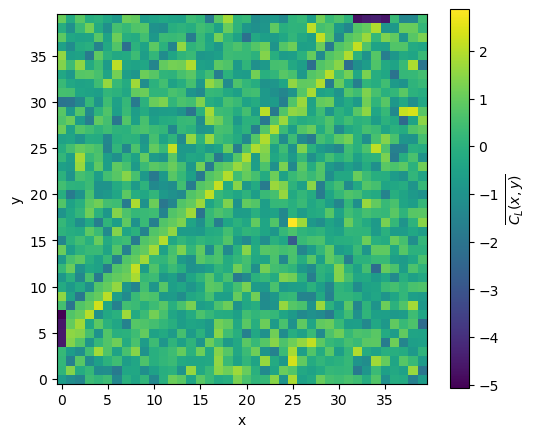

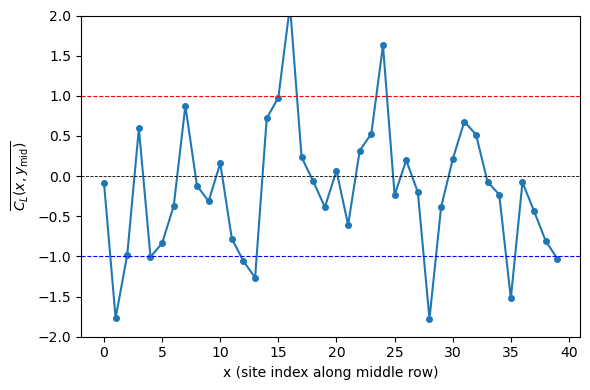

In [7]:
# CORRECT ONE FOR DISORDER-AVERAGED LOCAL CHERN MARKER ON Γ-PARENTS
#
# ============================================================
# BHZ parent -> base Hamiltonian
# New parents with multiple Γ's -> disorder ensemble
# For each Γ-parent: compute local Chern marker
# Finally:
#   (1) disorder-averaged C_L(x,y) over full parent
#   (2) disorder-averaged C_L(x, y_mid) along middle row
# ============================================================

import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

# ---------- Pauli ----------
tau_x = np.array([[0, 1], [1, 0]], dtype=complex)
tau_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
tau_z = np.array([[1, 0], [0, -1]], dtype=complex)

# ---------- Indexing ----------
def site_index(x, y, orb, Lx):
    """site linear = y*Lx + x, then *2 for orbitals + orb"""
    return 2 * (y * Lx + x) + orb

def inverse_site_index(i, Lx):
    """Inverse of site_index: from basis index i -> (x, y, orb)."""
    site = i // 2
    orb = i % 2
    y = site // Lx
    x = site % Lx
    return x, y, orb

# ---------- Parent BHZ (Eq. S16) ----------
def build_BHZ_parent(Lx, Ly, t=2.0, t0=1.0, m=2.0):
    """
    Real-space BHZ (spinless) with open boundaries.
    H_on = (4 t0 - m) τ_z
    H_x  = -t0 τ_z - i (t/2) τ_x
    H_y  = -t0 τ_z - i (t/2) τ_y
    Returns: H (csr), shape (2*Lx*Ly, 2*Lx*Ly)
    """
    N = 2 * Lx * Ly
    rows, cols, data = [], [], []

    onsite = (4.0 * t0 - m) * tau_z
    Tx = -t0 * tau_z - 1j * (t / 2.0) * tau_x
    Ty = -t0 * tau_z - 1j * (t / 2.0) * tau_y

    # On-site
    for x in range(Lx):
        for y in range(Ly):
            for a in (0, 1):
                ia = site_index(x, y, a, Lx)
                for b in (0, 1):
                    ib = site_index(x, y, b, Lx)
                    rows.append(ia); cols.append(ib); data.append(onsite[a, b])

    # +x hopping (and H.c.)
    for x in range(Lx - 1):
        for y in range(Ly):
            for a in (0, 1):
                ia = site_index(x, y, a, Lx)
                for b in (0, 1):
                    ib = site_index(x + 1, y, b, Lx)
                    v = Tx[a, b]
                    rows += [ia, ib]; cols += [ib, ia]; data += [v, np.conjugate(v)]

    # +y hopping (and H.c.)
    for x in range(Lx):
        for y in range(Ly - 1):
            for a in (0, 1):
                ia = site_index(x, y, a, Lx)
                for b in (0, 1):
                    ib = site_index(x, y + 1, b, Lx)
                    v = Ty[a, b]
                    rows += [ia, ib]; cols += [ib, ia]; data += [v, np.conjugate(v)]

    H = sp.csr_matrix((data, (rows, cols)), shape=(N, N), dtype=complex)
    return H

# ---------- Brane (arbitrary angle) ----------
def brane_mask(Lx, Ly, theta=None, S=None, x_u=12.0, x_d=6.0, xt_u=1.0, xt_d=2.0, inclusive=True):
    """
    Return boolean mask (length = 2*Lx*Ly) for DOFs inside the brane.
    Brane is the strip between two lines with slope S = tan(theta):
        y_u(x) = S*(x - xt_u) + x_u
        y_d(x) = S*(x - xt_d) + x_d
    """
    if S is None:
        if theta is None:
            raise ValueError("Provide either theta or S.")
        S = np.tan(theta)

    yu = np.zeros(Lx, dtype=float)
    yd = np.zeros(Lx, dtype=float)
    for x in range(Lx):
        yu[x] = S * (x - xt_u) + x_u
        yd[x] = S * (x - xt_d) + x_d
        if yd[x] > yu[x]:
            yu[x], yd[x] = yd[x], yu[x]  # ensure yu >= yd

    mask_sites = np.zeros((Ly, Lx), dtype=bool)  # [y, x]
    for x in range(Lx):
        y_top = yu[x]; y_bot = yd[x]
        for y in range(Ly):
            inside = (y_bot <= y <= y_top) if inclusive else (y_bot < y < y_top)
            if inside:
                mask_sites[y, x] = True

    # Repeat for the 2 orbitals per site
    mask_orb = np.repeat(mask_sites.flatten(), 2)  # flatten() is C-order: index = y*Lx + x
    return mask_orb

# ---------- Schur complement (kept, but not used in main here) ----------
def schur_ptb(Hparent, mask_in, E=0.0, eta=1e-6, permc_spec="MMD_AT_PLUS_A", make_hermitian=True):
    idx_in  = np.flatnonzero(mask_in)
    idx_out = np.flatnonzero(~mask_in)

    # Extract blocks
    H11 = Hparent[idx_in[:, None], idx_in].tocsc()
    H22 = Hparent[idx_out[:, None], idx_out].tocsc()
    H12 = Hparent[idx_in[:, None], idx_out].tocsr()
    H21 = Hparent[idx_out[:, None], idx_in].tocsr()

    # Stabilize and factorize H22
    n_out = H22.shape[0]
    shift = (-E - 1j * eta)
    H22s = H22 + shift * sp.identity(n_out, dtype=complex, format="csc")
    lu = spla.splu(H22s, permc_spec=permc_spec, diag_pivot_thresh=1.0)

    # Solve for multiple RHS: H22s X = H21
    X = lu.solve(H21.toarray())              # shape: (n_out, n_in)
    HX = H12 @ sp.csr_matrix(X)              # (n_in, n_in)
    Hptb = (H11 - HX).tocsr()
    if make_hermitian:
        Hptb = 0.5 * (Hptb + Hptb.getH())
    return Hptb

# ---------- Utilities ----------
def full_spectrum(H):
    """All eigenvalues of a Hermitian sparse matrix H (dense solve)."""
    return np.linalg.eigvalsh(H.toarray())

def ith_density_from_eigvec(vec, Lx, Ly):
    """vec is length 2*Lx*Ly; returns rho[y,x] = sum_orb |psi|^2."""
    psi_site_orb = vec.reshape(Lx*Ly, 2)
    dens_site = np.sum(np.abs(psi_site_orb)**2, axis=1)
    return dens_site.reshape(Ly, Lx)

# ---------- Local Chern marker helpers ----------
def compute_local_chern_marker_subspace(H_sparse, Lx, Ly, idx_subset=None,
                                        energy_threshold=0.0,
                                        title="Local Chern marker",
                                        do_plot=False):
    """
    Generic local Chern marker for a subspace of the full Hilbert space.
    - H_sparse: full Hamiltonian in parent basis (scipy sparse).
    - idx_subset: indices of DOFs to keep (None -> all DOFs).
    Returns CL_map[Ly, Lx] and eigenvalues in the subspace.
    If do_plot=True, also shows the 2D map.
    """
    N_full = H_sparse.shape[0]
    if idx_subset is None:
        idx_subset = np.arange(N_full, dtype=int)
    idx_subset = np.asarray(idx_subset, dtype=int)
    N_sub = idx_subset.size

    # Subspace Hamiltonian
    H_sub = H_sparse[idx_subset[:, None], idx_subset].toarray()
    H_sub = 0.5 * (H_sub + H_sub.conj().T)  # enforce Hermiticity

    # Diagonalize
    evals, evecs = np.linalg.eigh(H_sub)

    # Occupied states
    occ_mask = evals < energy_threshold
    if not np.any(occ_mask):
        raise ValueError("No occupied states found below threshold in subspace.")
    psi_occ = evecs[:, occ_mask]          # (N_sub, N_occ)
    P = psi_occ @ psi_occ.conj().T        # (N_sub, N_sub)
    I = np.eye(N_sub, dtype=complex)
    Q = I - P

    # Position operators in the subspace, using parent coordinates
    X = np.zeros((N_sub, N_sub), dtype=complex)
    Y = np.zeros((N_sub, N_sub), dtype=complex)
    for a, i_glob in enumerate(idx_subset):
        x, y, orb = inverse_site_index(i_glob, Lx)
        X[a, a] = x
        Y[a, a] = y

    # Ĉ_L = -4π Im[P X Q Y P]
    C_op = -4.0 * np.pi * np.imag(P @ X @ Q @ Y @ P)
    C_diag = np.real(np.diag(C_op))

    # Accumulate per site (sum over orbitals)
    CL_map = np.zeros((Ly, Lx), dtype=float)
    for a, i_glob in enumerate(idx_subset):
        x, y, orb = inverse_site_index(i_glob, Lx)
        CL_map[y, x] += C_diag[a]

    if do_plot:
        plt.figure(figsize=(5.2, 4.6))
        im = plt.imshow(CL_map, origin="lower", interpolation="nearest")
        plt.colorbar(im, shrink=0.9, label=r"$C_L(x,y)$")
        plt.xlabel("x"); plt.ylabel("y")
        plt.title(title)
        plt.tight_layout(); plt.show()

    return CL_map, evals

# (PTB-specific Chern function kept but unused in this script)
def compute_local_chern_marker_ptb(Hptb, Lx, Ly, idx_in,
                                   energy_threshold=0.0,
                                   title="PTB: Local Chern marker"):
    # (unchanged from your original, but not used in main)
    idx_in = np.asarray(idx_in, dtype=int)
    N_sub = idx_in.size

    H_sub = Hptb.toarray()
    H_sub = 0.5 * (H_sub + H_sub.conj().T)
    evals, evecs = np.linalg.eigh(H_sub)

    occ_mask = evals < energy_threshold
    if not np.any(occ_mask):
        raise ValueError("No occupied states found below threshold in PTB.")
    psi_occ = evecs[:, occ_mask]
    P = psi_occ @ psi_occ.conj().T
    I = np.eye(N_sub, dtype=complex)
    Q = I - P

    X = np.zeros((N_sub, N_sub), dtype=complex)
    Y = np.zeros((N_sub, N_sub), dtype=complex)
    for a, i_glob in enumerate(idx_in):
        x, y, orb = inverse_site_index(i_glob, Lx)
        X[a, a] = x
        Y[a, a] = y

    C_op = -4.0 * np.pi * np.imag(P @ X @ Q @ Y @ P)
    C_diag = np.real(np.diag(C_op))

    CL_map = np.zeros((Ly, Lx), dtype=float)
    brane_sites = np.zeros((Ly, Lx), dtype=bool)
    for a, i_glob in enumerate(idx_in):
        x, y, orb = inverse_site_index(i_glob, Lx)
        CL_map[y, x] += C_diag[a]
        brane_sites[y, x] = True

    return CL_map, evals

# ---------- Main: disorder average over Γ-parents ----------
if __name__ == "__main__":
    # Lattice + BHZ params
    Lx, Ly = 40, 40
    t, t0, m = 1.0, 0.5, 3.0

    print(f"Lattice: {Lx} x {Ly}  -> dim(H) = {2*Lx*Ly}")

    # Build original parent (base BHZ)
    Hparent = build_BHZ_parent(Lx, Ly, t=t, t0=t0, m=m)

    # Brane mask (only needed to define 'outside' for Γ)
    deg = 45
    theta = np.deg2rad(deg)
    mask_in = brane_mask(
        Lx, Ly,
        theta=theta, S=None,
        x_u=8.0, x_d=6.0,
        xt_u=1.0, xt_d=2.0,
        inclusive=True
    )
    idx_in  = np.flatnonzero(mask_in)
    idx_out = np.flatnonzero(~mask_in)
    nin, nout = int(mask_in.sum()), int((~mask_in).sum())
    print(f"Inside DOF: {nin} | Outside DOF: {nout}")

    # Extract original blocks
    H11 = Hparent[idx_in[:, None],  idx_in].tocsc()
    H22 = Hparent[idx_out[:, None], idx_out].tocsc()
    H12 = Hparent[idx_in[:, None],  idx_out].tocsr()
    H21 = Hparent[idx_out[:, None], idx_in].tocsr()

    # Disorder parameters
    omega = 1          # strength of deviation in Γ: 1 + δ, δ∈[-ω, ω]
    n_real = 20          # number of disorder realizations
    print(f"Disorder averaging over {n_real} realizations with omega = {omega}")

    # Accumulator for disorder-averaged C_L(x,y)
    CL_avg = np.zeros((Ly, Lx), dtype=float)

    # Loop over disorder realizations
    for r in range(n_real):
        rng = np.random.default_rng(seed=r)  # different seed each realization
        rand_offsets = rng.uniform(-omega, omega, size=nout)
        # Gamma = np.diag(1.0 + rand_offsets)
                # Gamma = np.diag(1.0 + rand_offsets)
        Gamma = np.eye(nout) + rng.uniform(-omega, omega, size=(nout, nout))


        # Build Γ-transformed parent Htilde
        H12_t = (H12 @ sp.csr_matrix(Gamma)).tocsr()
        H21_t = (sp.csr_matrix(Gamma.conj().T) @ H21).tocsr()
        H22_t = (sp.csr_matrix(Gamma.conj().T) @ H22 @ sp.csr_matrix(Gamma)).tocsc()

        N = Hparent.shape[0]
        Htilde = sp.lil_matrix((N, N), dtype=complex)
        Htilde[idx_in[:, None],  idx_in]  = H11
        Htilde[idx_in[:, None],  idx_out] = H12_t
        Htilde[idx_out[:, None], idx_in]  = H21_t
        Htilde[idx_out[:, None], idx_out] = H22_t
        Htilde = Htilde.tocsr()

        # Local Chern marker for this Γ-parent (no plotting here)
        CL_tilde, _ = compute_local_chern_marker_subspace(
            Htilde, Lx, Ly,
            idx_subset=None,
            energy_threshold=0.0,
            title=f"Γ-parent realization {r}",
            do_plot=False
        )

        CL_avg += CL_tilde

        print(f"  Realization {r+1}/{n_real} done.")

    # Disorder-averaged C_L
    CL_avg /= n_real

    # -------------------------------------------------
    # (1) Plot disorder-averaged local Chern marker map
    # -------------------------------------------------
    plt.figure(figsize=(5.5, 4.8))
    im = plt.imshow(CL_avg, origin="lower", interpolation="nearest")
    plt.colorbar(im, shrink=0.9, label=r"$\overline{C_L(x,y)}$")
    plt.xlabel("x")
    plt.ylabel("y")
    # plt.title("Disorder-averaged local Chern marker (Γ-parents)")
    plt.tight_layout()
    plt.show()

    # -------------------------------------------------
    # (2) Plot disorder-averaged C_L along the middle row
    # -------------------------------------------------
    y_mid = Ly // 2
    x_positions = np.arange(Lx)
    CL_line_avg = CL_avg[y_mid, :]

    plt.figure(figsize=(6.0, 4.0))
    plt.plot(x_positions, CL_line_avg, "o-", ms=4)
    plt.axhline(1.0, color="r", lw=0.8, ls="--")
    plt.axhline(0.0, color="k", lw=0.6, ls="--")
    plt.axhline(-1.0, color="b", lw=0.8, ls="--")
    plt.xlabel("x (site index along middle row)")
    plt.ylabel(r"$\overline{C_L(x,y_{\mathrm{mid}})}$")
    plt.ylim(-2,2)
    # plt.title("Disorder-averaged local Chern marker along middle row")
    plt.tight_layout()
    plt.show()
